In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree
from imblearn.over_sampling import SMOTE 
from xgboost import XGBClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Integration and preparation


- Reading the training csv file into a dataframe
- dropping the ID column from the data

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/traindata.csv')
df = df.drop(columns=['ID'])

- Encoding string categorical columns using label encoder
- NB: No scaling was performed as Decision tree classifier is used and It is not affected with data variance.

In [ ]:
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)

- Splitting the dataframe to features dataframe and label dataframe

In [ ]:
X = df.drop('Class',axis=1)
y = df['Class']

- Performing PCA on all features except 'protocol_type','src_bytes', 'level' as they showed biggest importance in training

In [ ]:
imp_data = X[['protocol_type','src_bytes', 'level']]
rest_data = X.drop(columns= ['protocol_type','src_bytes', 'level'])
pca = PCA(n_components=1)
X_data = pca.fit_transform(rest_data)
X_data = pd.DataFrame(X_data)
X_data = pd.concat([X_data, imp_data], axis= 1)

In [ ]:
X_data

,0,protocol_type,src_bytes,level
0,1225.036321,1,270,21
1,231.537832,1,287,21
2,1150.748464,1,830,11
3,-226.841426,1,268,21
4,-479.261614,1,0,11
...,...,...,...,...
22997,-458.069255,1,0,21
22998,-497.193346,1,0,19
22999,-492.902230,1,0,21
23000,-476.868089,2,413,17


- Plotting Data distribution amoung both classes

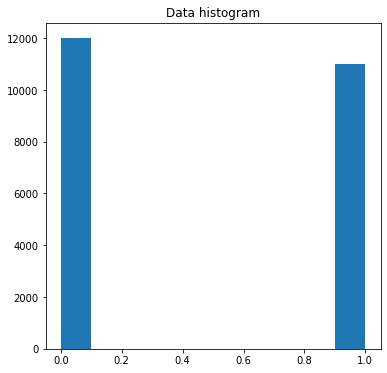

In [ ]:
fig = plt.figure(figsize =(6, 6))
plt.title("Data histogram") 
plt.hist(y) 
plt.show()

- Using SMOTE algorithm to oversample the attack class samples to equal the normal sample

In [ ]:
oversampling = SMOTE(random_state= 42)
X_new, y_new = oversampling.fit_resample(X_data, y,)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


- Plotting Data distribution after oversampling

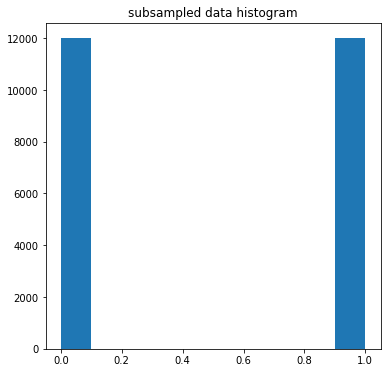

In [ ]:
fig = plt.figure(figsize =(6, 6))
plt.title("subsampled data histogram") 
plt.hist(y_new) 
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0, stratify= y_new)

# Decision Tree model

***Analysis of the classifier behviour***

- plotting the features importance according to this classifier
- Took the 4 most important features
- Several trials afterwards showed the most important ones after pruning are only 3
- They are 'protocol_type', 'src_bytes' and 'level'
- The rest of the features where transformed to 1 feature using PCA.
- According to this reference: https://dorukkilitcioglu.com/2018/08/11/pca-decision-tree.html
- Due to the sparsity of some features PCA can be useful to avoid information loss in sparse features


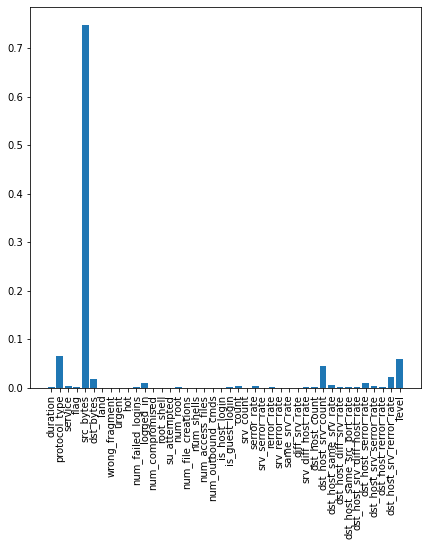

In [ ]:
clf = DecisionTreeClassifier().fit(X,y)
imp = clf.feature_importances_
plt.figure(figsize=(7,7))
plt.bar([x for x in X.columns.astype('string')], imp)
plt.xticks(rotation=90)
plt.show()

# Post Pruning

reference: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

- Getting the cost compexity pruning path from our trained model
- In order to extract different alpha and impurities values

In [ ]:
clf = DecisionTreeClassifier().fit(X_train,y_train)
path = clf.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

- Plotting Total Impurity vs effective alpha for training set

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

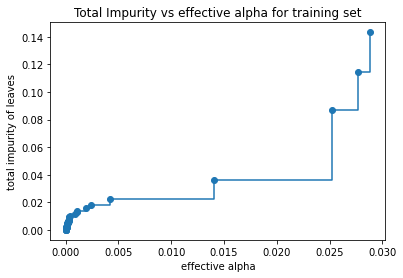

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3566382738182799


- Different ccp_alpha values vs depth and also vs number of nodes
- Accordingly, max depth and max leaf nodes were chosed that correspend the ccp_alpha chosen value.


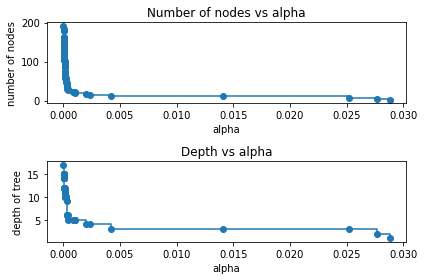

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

- I chose the value before the validation accuracy becomes better than training accuracy
- Which is between 0.011 and 0.015
- the one I chose was 0.013

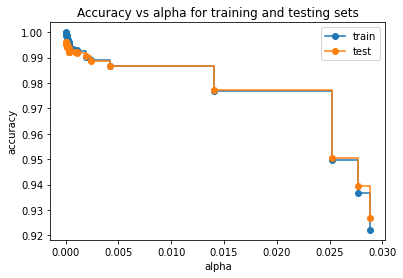

In [ ]:
train_scores = [clf.score(X_train,y_train) for clf in clfs]
test_scores = [clf.score(X_test,y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# Final Classifier

- Splitting the data to training and validation with ratio 80,20% respectively.

- Training the data using Decision tree classifier
- using ccp_alpha parameter determined by previous post pruning

In [ ]:
clf = DecisionTreeClassifier(max_depth= 3, max_leaf_nodes=8, ccp_alpha=0.013)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print('f1-score {}'.format(f1_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3001
           1       0.98      0.99      0.99      3000

    accuracy                           0.99      6001
   macro avg       0.99      0.99      0.99      6001
weighted avg       0.99      0.99      0.99      6001

f1-score 0.9867330016583749


- Plotting the features importance of the final classification

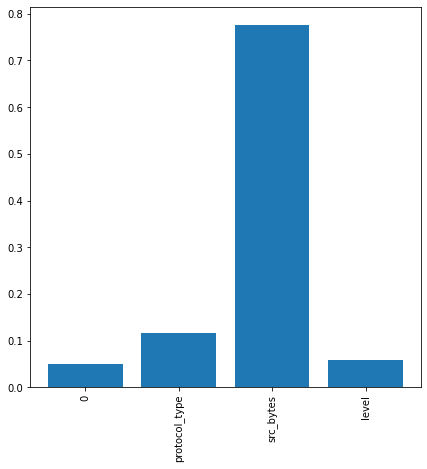

In [ ]:
imp = clf.feature_importances_
plt.figure(figsize=(7,7))
plt.bar([x for x in X_data.columns.astype('string')], imp)
plt.xticks(rotation=90)
plt.show()

- Plotting a tree produced by the Final Classifier

[Text(590.1923076923077, 951.3000000000001, 'src_bytes <= 21.5\ngini = 0.5\nsamples = 18001\nvalue = [9000, 9001]'),
 Text(214.6153846153846, 679.5, '0 <= -475.268\ngini = 0.127\nsamples = 8798\nvalue = [599, 8199]'),
 Text(107.3076923076923, 407.70000000000005, 'gini = 0.011\nsamples = 7557\nvalue = [40, 7517]'),
 Text(321.9230769230769, 407.70000000000005, 'protocol_type <= 0.5\ngini = 0.495\nsamples = 1241\nvalue = [559, 682]'),
 Text(214.6153846153846, 135.89999999999998, 'gini = 0.0\nsamples = 609\nvalue = [0, 609]'),
 Text(429.2307692307692, 135.89999999999998, 'gini = 0.204\nsamples = 632\nvalue = [559, 73]'),
 Text(965.7692307692307, 679.5, 'protocol_type <= 0.5\ngini = 0.159\nsamples = 9203\nvalue = [8401, 802]'),
 Text(751.1538461538462, 407.70000000000005, 'src_bytes <= 286.5\ngini = 0.41\nsamples = 619\nvalue = [178, 441]'),
 Text(643.8461538461538, 135.89999999999998, 'gini = 0.0\nsamples = 178\nvalue = [178, 0]'),
 Text(858.4615384615385, 135.89999999999998, 'gini = 0.0\n

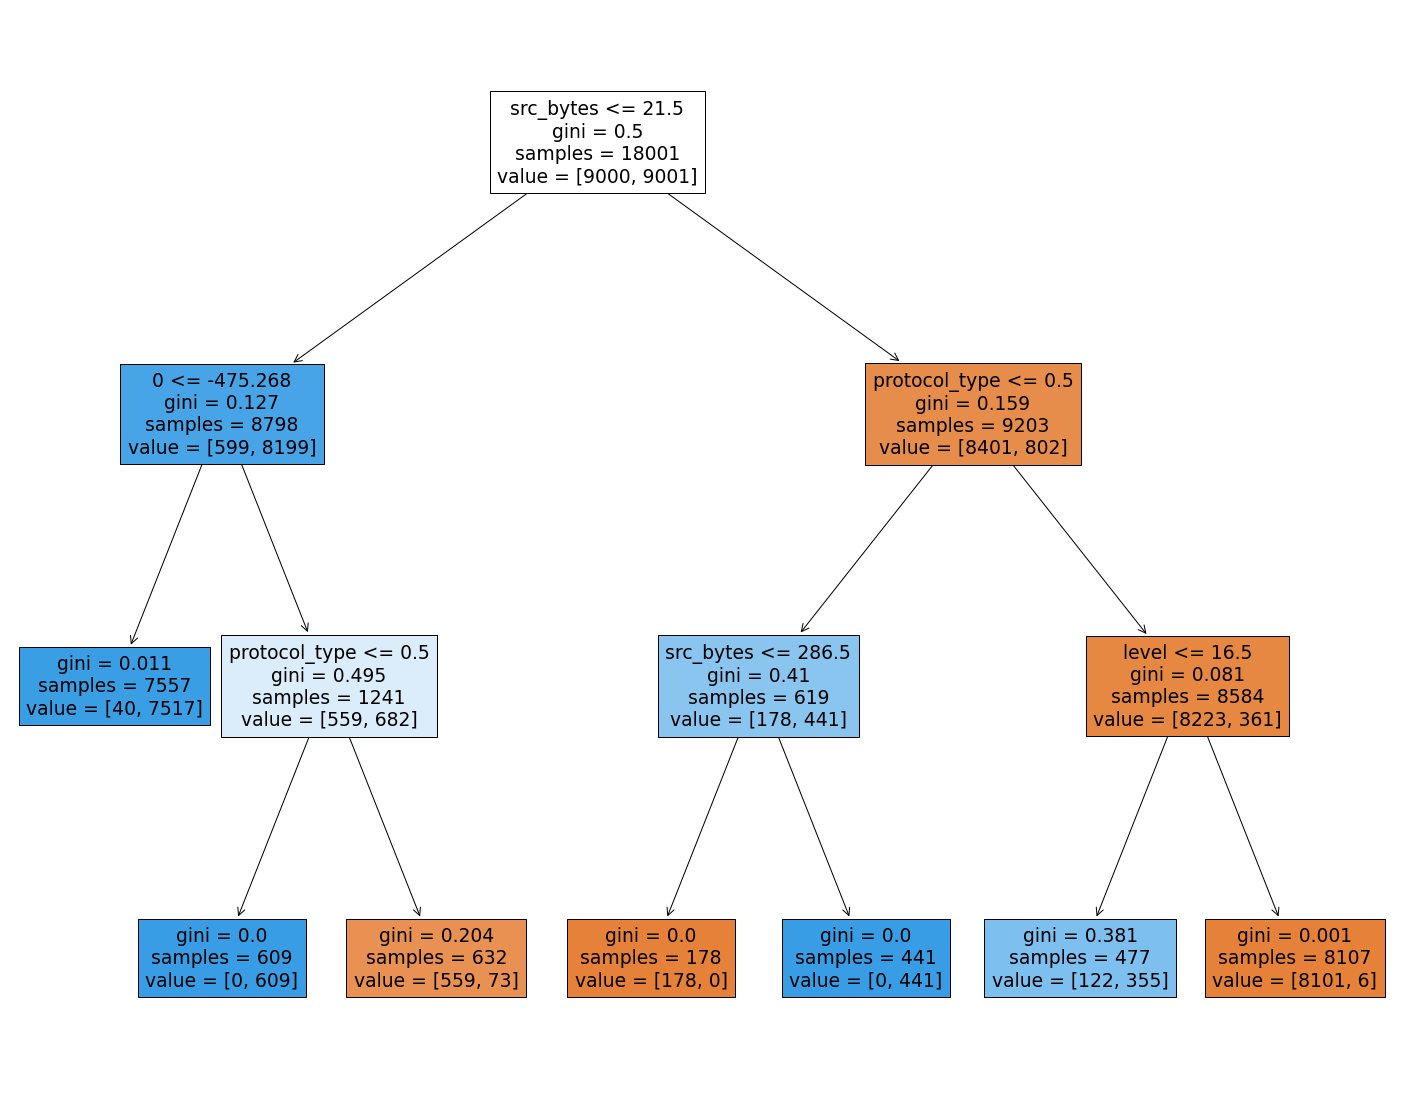

In [ ]:
fig = plt.figure(figsize=(25,20))
tree.plot_tree(clf, 
              feature_names= X_data.columns,
              filled=True)

# Testing

- Reading the Test data and putting it in a dataframe
- Removing the ID column as it is not a feature like in training data
- Using Label Encoder to encode string categorical features

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/testdata.csv')
test= test.drop(columns='ID')
test = test.apply(le.fit_transform)

- Performing same data preparation like in training data in order for the model to be able to predict them
- PCA is performed to extract a feature from all other features except 'protocol_type','src_bytes' and 'level' features
- it is concatenated with the left features to form new test data like in training

In [ ]:
imp_data = test[['protocol_type','src_bytes', 'level']]
rest_data = test.drop(columns= ['protocol_type','src_bytes', 'level'])
pca = PCA(n_components= 1)
test = pca.fit_transform(rest_data)
test = pd.DataFrame(test)
test = pd.concat([test, imp_data], axis= 1)

In [ ]:
test

,0,protocol_type,src_bytes,level
0,-438.042097,1,28,16
1,-535.359229,1,0,21
2,-494.570438,2,49,17
3,-5.202054,1,341,21
4,-523.148374,0,552,18
...,...,...,...,...
22496,1023.364275,1,272,21
22497,-12.632845,1,134,11
22498,-530.352363,1,0,21
22499,2507.341561,1,173,21


- Training the classifier using the whole training dataset using the chosen parameters
- predicting the labels of test data using the trained classifier

In [ ]:
clf = DecisionTreeClassifier(max_depth= 3, max_leaf_nodes=8,ccp_alpha=0.013).fit(X_new,y_new)
y_pred = clf. predict(test)

- Creating a dataset holding the predicted labels and an ID assigned to each sample
- Displaying the output Dataframe

In [ ]:
id = range(0, len(test))
ypred_df = pd.DataFrame({'ID':  id,
        'Class': y_pred})
ypred_df

,ID,Class
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
22496,22496,0
22497,22497,1
22498,22498,1
22499,22499,0
